# NX31 Model Project

___
DELETE !

Notes, and things to remember before handing in!

- notes in parentheses
- 
___

# Introduction

(import packages - erase those we do not use)

We will examine the overlapping generations model (OLG), first the basic OLG model with consumption and savings, second will expand with two extensions, the pay as you go (PAYG) method and the fully funded (FF) method.
In the OLG model there is typical two generation, a generation working and a generation living on pension.
The PAYG is similar to state pension where the young generation pay a tax and this tax is used to fund the pension for the old generation and the FF model is more like a private pension savings account, where the young generation save for when they retire.

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import math
import OLGModel

import numecon_linalg

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## The General OLG model:

As mentioned, we start with our general OLG model with savings. This model looks as shown below.

Population growth or Labor growth:

\begin{eqnarray*}
L_t=(1+n) L_{t-1}
\end{eqnarray*}

Utility:

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

Contraints:

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

( lav docstrings til funktionerne! )

In [2]:
def c1_gen(w,s):
    return w-s

def c2_gen(r,s):
    return (1+r)*s

def utility(c1,c2,rho):
    rho>-1
    return np.log(c1)+(1/(1+rho))*np.log(c2)

( lav dem rigtig globale! )

In [3]:
#Global definitions of parameters
alpha = 1/3
n = 0.02
rho = 0.04
A = 1
delta = 1

## Firm problem

The firm

The firms optimization will be the same in all extensions of the OLG model

Output function is given by:

\begin{eqnarray*}
F(K_t,L_t)=Y_t=A(K_t)^\alpha(L_t)^{1-\alpha}
\end{eqnarray*}

Profit function is given by:

\begin{eqnarray*}
\Pi(K_t,L_t)=F(K_t,L_t)-w_tL_t-(r_t+\delta)K_t
\end{eqnarray*}

With interest and wages being.

\begin{eqnarray*}
r_t = \alpha Ak_t^{\alpha-1}-\delta
\end{eqnarray*}

\begin{eqnarray*}
w_t = (1-\alpha) Ak_t^{\alpha}
\end{eqnarray*}



- $Y$ is output
- $A$ is total factor productivity (TFP)
- $K$ is capital
- $L$ is population / labor force
- $\alpha$ is the share of capital
- $\Pi$ is profit
- $w$ is wage
- $r$ is the real interest rate
- $\delta$ is the degree of depreciation


We will check our results using the sympy package to make sure we have found the correct functions for the interest rate and wages.

In [4]:
sm.init_printing(use_unicode=True)

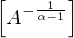

In [5]:
K = sm.symbols('K')
L = sm.symbols('L')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
y = sm.symbols('y')
k = sm.symbols('k')
Y = A*(K**alpha)*(L**(1-alpha))
yy = Y/L
k = K/L
f = k**alpha
y = sm.Eq(k,(A*f))
sy = sm.solve(y,k)
sy

In [6]:
K = sm.symbols('K')
L = sm.symbols('L')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
w = sm.symbols('w')
r = sm.symbols('r')
y = sm.symbols('y')
#k = sm.symbols('k')
Pi = sm.symbols('Pi')
Pi = A*(K**alpha)*(L**(1-alpha))-w*L-(r+delta)*K
print(Pi)
f1 = sm.diff(Pi,K)
f2 = sm.diff(Pi,L)
print(f1)
print(f2)
f1solve = sm.solve(A*K**alpha*L**(-alpha + 1)*alpha/K - delta - r, r)[0]
f2solve = sm.solve(A*K**alpha*L**(-alpha + 1)*(-alpha + 1)/L - w, w)[0]
print(f1solve)
print(f2solve)
print(f'r = (A*K**alpha*L*L**(-alpha)*alpha/K - delta)')
print(f'w = (-A*K**alpha*L**(-alpha)*(alpha - 1))')

A*K**alpha*L**(-alpha + 1) - K*(delta + r) - L*w
A*K**alpha*L**(-alpha + 1)*alpha/K - delta - r
A*K**alpha*L**(-alpha + 1)*(-alpha + 1)/L - w
A*K**alpha*L*L**(-alpha)*alpha/K - delta
-A*K**alpha*L**(-alpha)*(alpha - 1)
r = (A*K**alpha*L*L**(-alpha)*alpha/K - delta)
w = (-A*K**alpha*L**(-alpha)*(alpha - 1))


In [7]:
#k = sm.symbol('k')
#alpha = sm.symbol('alpha')
#rho = sm.symbol('rho')
#n = sm.symbol('n')

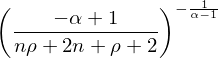

In [16]:
ss = sm.Eq(k,(((1-alpha)*(k**alpha))/((2+rho)*(1+n))))
kss = sm.solve(ss,k)[0]
kss

In [17]:
ss_func = sm.lambdify((alpha,n,rho),kss)

In [18]:
ss_func(1/3,0.02,0.04)

In [20]:
alpha = 1/3
n = 0.02
rho = 0.04

In [22]:
obj_kss = lambda kss: kss - ((1-alpha)*(kss**alpha))/((2+rho)*(1+n))
result = optimize.root_scalar(obj_kss,bracket=[0.1,100],method='brentq')
result

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.18135001783804428

In [9]:
def output(K,L,alpha,A):
    return A*(K**alpha)*(L**(1 - alpha))
def profit(output,w,L,r,K,delta=1):
    return output-w*L-(r+delta)*K

In [10]:
#Solving the general model gives:
def r(k,alpha,A,delta):
    return alpha*A*k**(alpha-1)-delta
def w(k,alpha,A):
    return (1-alpha)*A*k**alpha

a: Guess on a k_ss, could be 1.6, or atleast lets start with that.
b: Calculate r_ss and w_ss
c: Solve the household problem
d: Calculate S (for the young)
e: k_sst (true) = s/1-n
f: Visualize your guesses


The true is the k_ss at the 45 degree line

g: k_sst-k_ss = 0

Tilbage til punkt a hvis nr. g ikke passer.

## Household problem


Now that the firm problem is solved, we solve for the household. We start by finding the savings function for the household.

In [11]:
sm.init_printing(use_unicode=True)

K = sm.symbols('K')
L = sm.symbols('L')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
rho = sm.symbols('rho')
s = sm.symbols('s')
n = sm.symbols('n')
U = sm.symbols('U')
w = sm.symbols('w')
r_plus = sm.symbols('r_t+1')

log(-s + w) + log(s*(r_t+1 + 1))/(rho + 1)
Eq(s, -1/(-s + w) + 1/(s*(rho + 1)))


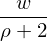

In [12]:
U = sm.log(w-s)+(1/(1+rho))*sm.log((1+r_plus)*s)
print(U)

u1 = sm.diff(U,s)

u = sm.Eq(s,u1)
u
print(u)
usolve = sm.solve(-1/(-s + w) + 1/(s*(rho + 1)),s)[0]

usolve

In [13]:
#a: Guess
k_ss = 0.6

#b: Calculate r_ss and w_ss for guess
r_ss = r(k_ss,alpha,A,delta)
w_ss = w(k_ss,alpha,A)
print('Interest Rate Steady State: ',r_ss)
print('Wages Steady State: ',w_ss)

#c: Solve household problem


print('Savings Steady State: ',s_ss)

c1 = c1_gen(w_ss,s_ss)
c2 = c2_gen(r_ss,s_ss)
util = utility(c1,c2,rho)
print('Consumption 1 Steady State: ', c1)
print('Consumption 2 Steady State: ', c2)
print('Utility Steady State: ', util)


k_sst = ((1-alpha)/((2+rho)*(1+n)))**(1/(1-alpha))
print(k_sst)

k_ss-k_sst == 0

TypeError: 'Symbol' object is not callable

## Interactive Figures

Below we plot the interative figures showing the transistion curve

In [ ]:
# Transitions kurver
OLGModel.interactive_transition_curve()

PAYG OLG model

Utility...

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

s.t.

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t(1-d)-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t + w_{t+1}d(1+n)
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

In [ ]:
def c1_payg(w,s,d):
    return w(1-d)-s

def c2_payg(r,s,w,d,n):
    return (1+r)*s+wd(1+n)

d = 0.12

FF model

Utility...

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

s.t.

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t(1-\tau)-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t + \tau(1+r_{t+1})w_t
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

In [ ]:
def c1_ff(w,s,tau):
    return w(1-tau)-s

def c2_ff(r,s,tau,w):
    return (1+r)*s+tau*(1+r)*w

tau = 0.13